In [127]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, datetime
import seaborn as sns
import csv

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd


Antes que nada, realizaremos una simple demostracion de la idea basica de DMD.
Defininiremos unos datos aleatorios, en la mayoria de implementaciones que hagamos, no  conoceremos las ecuaciones que gobiernan los datos obtenidos, aqui generaremos un set de datos a partir de ciertas ecuaciones, pero una vez el dataset hecho, olvidemonos que existen esas ecuaciones.


In [128]:
x = np.linspace(-10, 10, 100)
t = np.linspace(0, 6*np.pi, 80)
dt = t[2] - t[1]
Xm, Tm = np.meshgrid(x,t)

# Creamos tres patrones espaciotemporales
f1 = np.multiply(20-0.2*np.power(Xm, 2), np.exp((2.3j)*Tm))
f2 = np.multiply(Xm, np.exp(0.6j*Tm))
f3 = np.multiply(5*np.multiply(1/np.cosh(Xm/2), np.tanh(Xm/2)), 2*np.exp((0.1+2.8j)*Tm))

# Combinamos las señales y hacemos la matriz de datos
D = (f1 + f2 + f3).T

# Creamos las matrices para realizar el algoritmo DMD
X = D[:,:-1]
Y = D[:,1:]

A continuacion se graficara como se veria nuestro set de datos

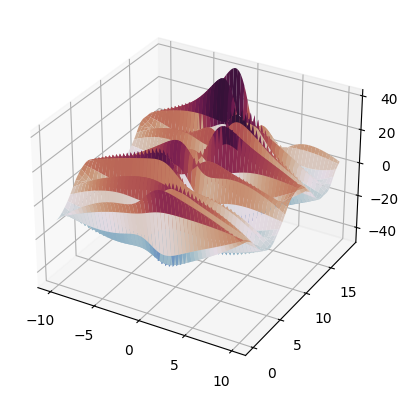

In [129]:
Xgrid, T = np.meshgrid(x,t)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(Xgrid, T, np.real(D.T), cmap=plt.cm.twilight_shifted)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

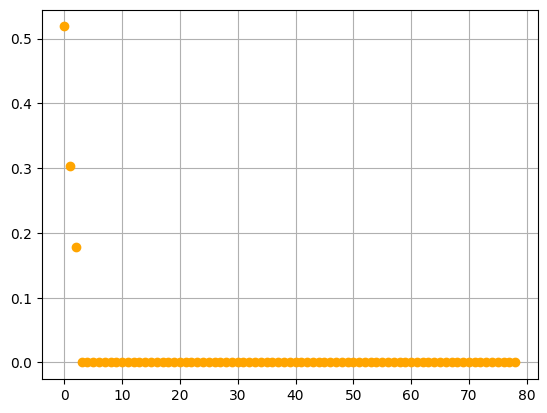

In [130]:
# SVD of input matrix
U,Sig,Vh = svd(X, False)
ax, fig = plt.subplots()
plt.plot(Sig/np.sum(Sig), 'o', color='orange')
plt.grid()
plt.show

Como se ha podido ver, hay tres valores singulares predominantes en nuestros datos, por lo que en vez de trabajar con el conjunto entero de datos, haremos un rank-truncation de su descomposicion DMD y nos quedaremos solo con estos tres modos. 

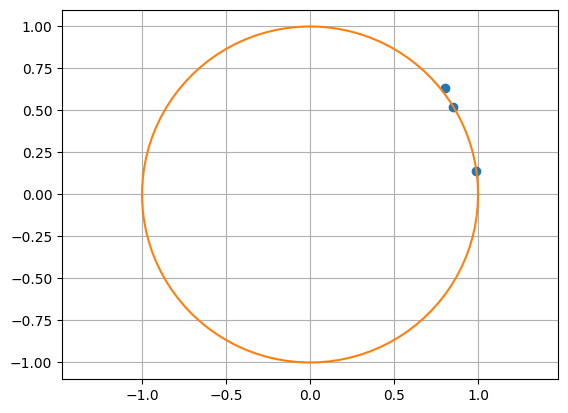

In [131]:
#SVD of input matrix
U2,Sig2,Vh2 = svd(X, False)

r = 3

U = U2[ : , : r]
Sig = np.diag(Sig2)[ : r, : r]
V = Vh2.conj().T[ : , : r]

#Build A tilde
Atil = U.conj().T @ Y @ V @ np.linalg.inv(Sig)

mu, W = np.linalg.eig(Atil)

fig, ax = plt.subplots(1,1)
x = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.real(mu), np.imag(mu), 'o')
plt.plot(np.cos(x), np.sin(x))
plt.axis('Equal')
plt.grid()
plt.show()

Cada autovalor en mu nos dice algo sobre el comportamiento dinamico de su correspondiente modo DMD. De esta informacion se pueden sacar muchas conclusiones. En este caso si el autovalor tiene parte imaginaria no nula, al modo DMD correspondiente a ese autovalor le corresponde una oscilacion. Si el autovalor esta exactamente sobre la circunferencia unidad, su DMD-mode oscila constantemente, si el autovalor esta dentro de la circunferencia unidad, su DMD-mode oscilara decayendo su amplitud con el tiempo. Y si el autovalor esta fuera de la circunferencia unidad, su DMD-mode la oscilacion correspondiente aumentara su amplitud con el tiempo.

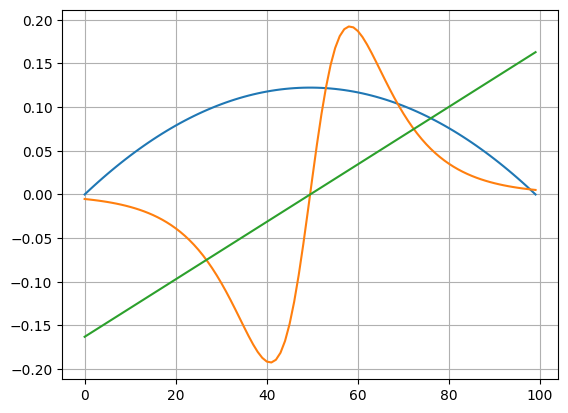

In [132]:
#Veamos los DMD modes

Phi = Y @ V @ np.linalg.inv(Sig) @ W

fig, ax = plt.subplots(1,1)

plt.plot(np.real(Phi[ : , 0]))
plt.plot(np.real(Phi[ : , 1]))
plt.plot(np.real(Phi[ : , 2]))

plt.grid()
plt.show()

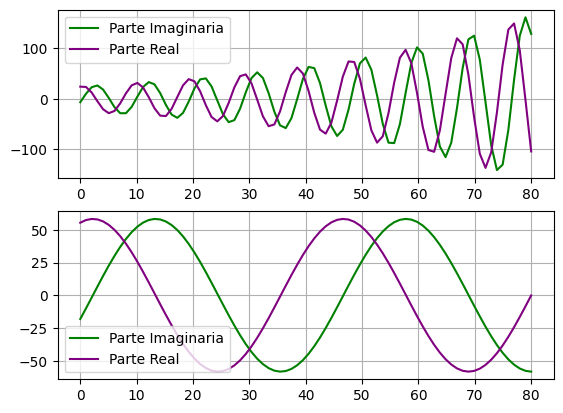

In [137]:
# Computando la evolucion en el tiempo de los DMD modes
b = np.linalg.pinv(Phi) @ X[:,0]
Psi = np.zeros([r, len(t)], dtype='complex')
for i,_t in enumerate(t):
    Psi[:,i] = np.multiply(np.power(mu, _t/dt), b)

fig, ax = plt.subplots(2,1)
x = np.linspace(0, 80, 80)
for i in range(2):
    ax[i].plot(x, np.imag(Psi[i :][1]), label='Parte Imaginaria', color='green')
    ax[i].plot(x, np.real(Psi[i :][1]), label='Parte Real', color='purple')
    ax[i].legend()
    ax[i].grid()
plt.show()

Los dos graficos de arriba la dinamica en el tiempo de dos DMD modes de los datos.
Si quisieramos una aproximacion de los datos en el futuro, solo multiplicamos las matrices Φ and Ψ. Los datos originales y la aproximacion por DMD son exactamente iguales en este caso.

In [134]:
#Reconstruccion DMD
D2 = Phi @ Psi
print(np.allclose(D, D2))

True


Pasaremos a la implementacion de DMD a el trading algoritmico de ETFs de acciones

In [50]:
#Funcion que me da la Matriz de Datos de los precios de cierre en la ventana temporal indicada

#Importamos los tickers de un archivo excel
f = open('consumerdiscr.csv', 'r')
reader = csv.reader(f)
tickers = [i.split(',')[0] for i in f.readlines()]

#Descargamos la data
#Formato fecha debe estar en mm-dd-yy
df = yf.download(tickers, start = "2018-01-01", end="2021-01-01")['Adj Close']
dft = df.T

#Conviertimos el panda dataframe en un vector con los precios de cada empresa en fila
consumerdiscr = dft.values

#Con este codigo verificamos que no haya Nans en los precios
x, y = consumerdiscr.shape
for i in range(x):
    for j in range(y):
        if np.isnan(consumerdiscr[i,j]) == True:
            print(f'Nan en {(i,j)}')

[*********************100%***********************]  52 of 52 completed


In [51]:
#Algotitmo DMD

#Se le pasan dos matrices las cuales son iguales excepto que X2 esta un dt adelantada de la X1
def dmd(X1, X2, truncate=None):

    #Realizamos la descomposicion SVD de la matriz X1
    U2,Sig2,Vh2 = np.linalg.svd(X1, False) # SVD of input matrix

    #Definimos donde truncare las matrices para trabajar con matrices cuadradas
    r = len(Sig2) if truncate is None else truncate # Rank truncation

    U = U2[:,:r]                    #
    Sig = np.diag(Sig2)[:r,:r]      #Truncamos las matrices de la descomposicion SVD
    V = Vh2.conj().T[:,:r]          #

    Atil = U.conj().T @ X2 @ V @ np.linalg.inv(Sig) # Construyo A tilde

    #Autodescomposicion de A tilde
    mu ,W = np.linalg.eig(Atil)

    Phi = X2 @ V @ np.linalg.inv(Sig) @ W # Construyo los DMD modes

    return mu, Phi

In [52]:
#Funcion que me predice el estado de si sistema en el tiempo t

def x_t(t, Phi, mu, dt, A):
    return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))

In [53]:
#Funcion que dados dos estados de tiempo (vectores), me devuelve la variacion promedio entre los elementos del
# primero y el ultimo

def variacion(a, b):
    variacion_elementos = []
    for i in range(len(a)):
        variacion_elementos.append((b[i] - a[i]) / a[i])
    return sum(variacion_elementos) / len(variacion_elementos)

#Ejemplo
a = [10,20,50]
b = [10,18,60]
print(variacion(a,b))
print(variacion(b,a))


0.03333333333333333
-0.018518518518518517


In [54]:
def acertividad(variacion_predecida, precios_actuales, precios_pasados):
    #Definimos una variable entera, la cual sera 0 si el algoritmo hizo una mala prediccion y sera 1 en caso contrario
    t = 0

    #Calculamos la variacion que tuvo el mercado
    variacion_real = variacion(precios_pasados, precios_actuales)
    
    #Comparamos si la tendencia que predijo el algoritmo es la misma que ocurrio en realidad
    if np.sign(variacion_real) == np.sign(variacion_predecida):
            t = 1
            
    return t 

In [56]:
#Funcion a la que le pasamos los dias en el pasado que queremos tomar en cuenta (mp) para predecir 
# el estado de las acciones mf dias en el futuro desde el dia mp

def resultado(mf, mp, Precios):

    #Definimos dos variables, la primera, por cuanto se multiplica el valor de nuestra cartera, la segunda
    # sera una lista de la evolucion de el valor de la misma
    estado = 1
    estados = []

    #El tiempo inicial sera el ultimo dato de precio que tiene el sistema, la columna de la matriz mp
    t = mp

    #Definimos el numero de iteraciones que hara el algoritmo
    #iteraciones = int(np.floor(Precios.shape[1] / mf))

    for i in range(0, Precios.shape[1] - mp, mf):
        #Definimos las matrices con las que construiremos los DMD Modes
        X1 = Precios[ : , i : i + mp]
        X2 = Precios[ : , i + 1 : i + mp + 1]

        #Realizamos la descomposicion DMD de nuestras matrices
        mu, Phi = dmd(X1,X2)
        
        #El salto de tiempo sera la cantidad de dias que predeciremos en el futuro
        dt = mf
        
        #Actualizamos t al tiempo en el que queremos precedir el precio de nuestra cartera
        t = t + mf

        #Este if evita un error de out of range cuando calculo la variacion real
        if i + mf + mp < Precios.shape[1]:
                
            #Calculamos los precios que tendra la cartera en el nuevo tiempo t
            xt = x_t(t, Phi, mu, dt, X1)

            #Calculamos la variacion predecida
            variacion_predecida = variacion(X2[ : , -1], xt)

            #Calculamos la varaicion real
            variacion_real = variacion(X2[ : , -1], Precios[ : , i + mf + mp])

            #Este if chequea que el t no este fuera de rango y si el algoritmo predijo que el precio va a subir
            # a la vez que el precio real efectivamente subio
            if t < Precios.shape[1] and variacion_predecida > 0:
                
                #El algoritmo compra, por lo que nuestra cartera va a sufrir la variacion que tenga el mercado
                estado = estado + estado * variacion_real

            #Con este for simplemente lleno la lista estados para luego poder plotearlos a la par de otros activos
            for j in range(mf):
                estados.append(estado)
        
    return(estados)


In [57]:
#Funcion que devolvera un heatmap con la acerividad que tuvo el algoritmo 

def HotSpots(MF,MP, Precios):
    comofue = np.zeros((MF, MP))

    for mp in range(1, MP + 1):
        for mf in range(1, MF + 1):

            #Definimos dos variables, las cuales, dividiendolas obtendremos la acertividad del algoritmo
            casos_favorables = 0
            casos_totales = 0

            #El tiempo inicial sera el ultimo dato de precio que tiene el sistema, la columna de la matriz mp
            t = mp

            #Definimos el numero de iteraciones que hara el algoritmo
            #iteraciones = int(np.floor(Precios.shape[1] / mf))

            for i in range(0, Precios.shape[1] - mp, mf):
                #Definimos las matrices con las que construiremos los DMD Modes
                X1 = Precios[ : , i : i + mp]
                X2 = Precios[ : , i + 1 : i + mp + 1]

                #Realizamos la descomposicion DMD de nuestras matrices
                mu, Phi = dmd(X1,X2)
                
                #El salto de tiempo sera la cantidad de dias que predeciremos en el futuro
                dt = mf
                
                #Actualizamos t al tiempo en el que queremos precedir el precio de nuestra cartera
                t = t + mf

                #Este if evita un error de out of range
                if i + mf + mp < Precios.shape[1]:
                
                    #Calculamos los precios que tendra la cartera en el nuevo tiempo t
                    xt = x_t(t, Phi, mu, dt, X1)

                    #Calculamos la variacion predecida
                    variacion_predecida = variacion(X2[ : , -1], xt)

                    #Calculamos la varaicion real
                    variacion_real = variacion(X2[ : , -1], Precios[ : , i + mf + mp])

                    #Este if chequea que el t no este fuera de rango y si el algoritmo predijo que el precio va a subir
                    # a la vez que el precio real efectivamente subio
                    if t < Precios.shape[1] and np.sign(variacion_predecida) == np.sign(variacion_real):
                        
                        casos_favorables += acertividad(variacion_predecida, Precios[:, t], X2[:,-1])
                        casos_totales += 1
                    else:
                        casos_totales += 1

            comofue[mf - 1, mp - 1] = casos_favorables / casos_totales
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax = sns.heatmap(comofue, annot=True, cbar=True, cmap='YlGn')
    plt.title(f"Efectividad de cada tupla (mf,mp)")
    plt.show()

C:\Users\Pedro\AppData\Local\Temp\ipykernel_128\3108260181.py:4: RuntimeWarning: overflow encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))
C:\Users\Pedro\AppData\Local\Temp\ipykernel_128\3108260181.py:4: RuntimeWarning: invalid value encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))


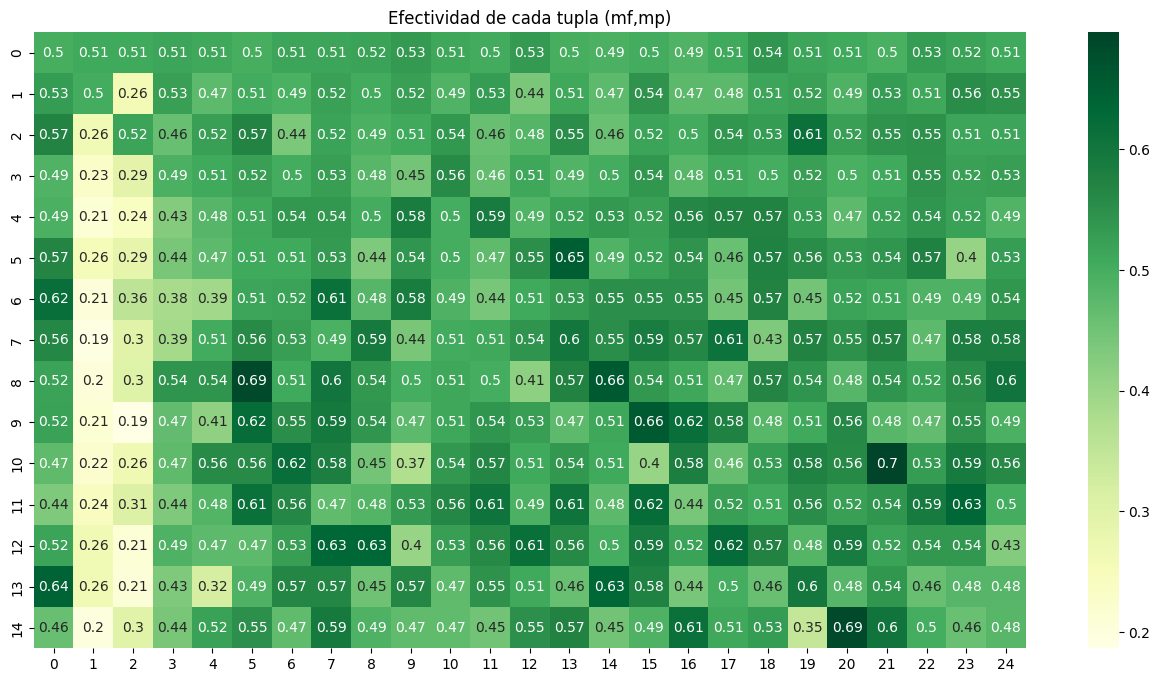

In [10]:
HotSpots(15, 25, consumerdiscr)

En las siguientes celdas, se descargaran los precios de diferentes carteras de inversion para compararlas aplicandoles el algoritmo a la vez que con el S&P500.

In [58]:
f = open('financial_sector.csv', 'r')
reader = csv.reader(f)
tickers = [i.split(',')[0] for i in f.readlines()]
df = yf.download(tickers, start = "2018-01-01", end="2021-01-01")['Adj Close']
dft = df.T
financial_sector = dft.values
x, y = financial_sector.shape
for i in range(x):
    for j in range(y):
        if np.isnan(financial_sector[i,j]) == True:
            print(f'Nan en {(i,j)}')

[*********************100%***********************]  65 of 65 completed


C:\Users\Pedro\AppData\Local\Temp\ipykernel_128\3108260181.py:4: RuntimeWarning: invalid value encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))


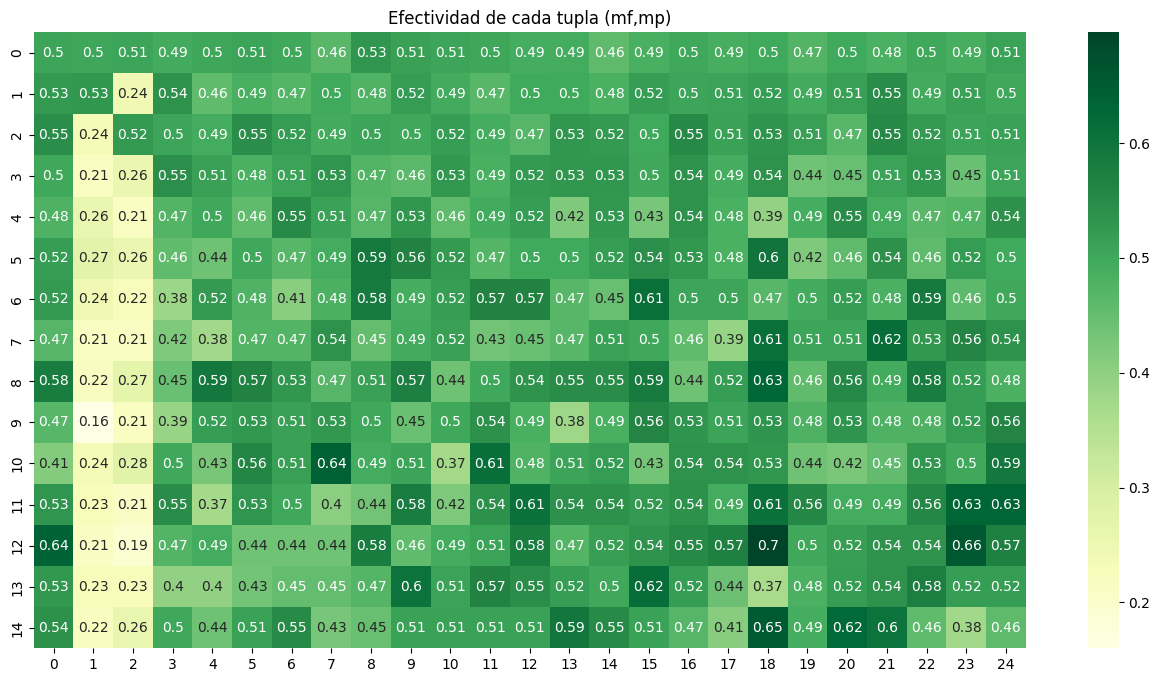

In [14]:
HotSpots(15,25, financial_sector)

In [59]:
f = open('health_care.csv', 'r')
reader = csv.reader(f)
tickers = [i.split(',')[0] for i in f.readlines()]
df = yf.download(tickers, start = "2018-01-01", end="2021-01-01")['Adj Close']
dft = df.T
health_care = dft.values
x, y = health_care.shape
for i in range(x):
    for j in range(y):
        if np.isnan(health_care[i,j]) == True:
            print(f'Nan en {(i,j)}')

[*********************100%***********************]  62 of 62 completed


C:\Users\Pedro\AppData\Local\Temp\ipykernel_4640\184215239.py:4: RuntimeWarning: invalid value encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))
C:\Users\Pedro\AppData\Local\Temp\ipykernel_4640\184215239.py:4: RuntimeWarning: overflow encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))


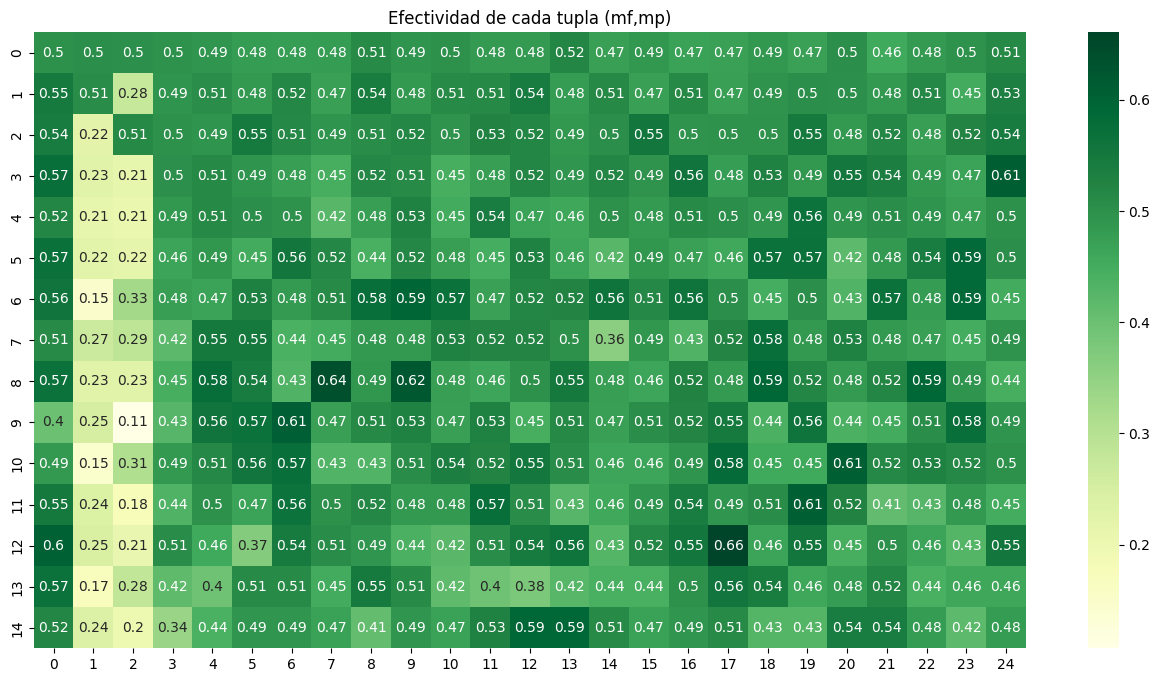

In [60]:
HotSpots(15,25, health_care)

In [61]:
f = open('info_tech.csv', 'r')
reader = csv.reader(f)
tickers = [i.split(',')[0] for i in f.readlines()]
df = yf.download(tickers, start = "2018-01-01", end="2021-01-01")['Adj Close']
dft = df.T
info_tech = dft.values
x, y = info_tech.shape
for i in range(x):
    for j in range(y):
        if np.isnan(info_tech[i,j]) == True:
            print(f'Nan en {(i,j)}')

[*********************100%***********************]  73 of 73 completed


C:\Users\Pedro\AppData\Local\Temp\ipykernel_128\3108260181.py:4: RuntimeWarning: overflow encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))
C:\Users\Pedro\AppData\Local\Temp\ipykernel_128\3108260181.py:4: RuntimeWarning: invalid value encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))


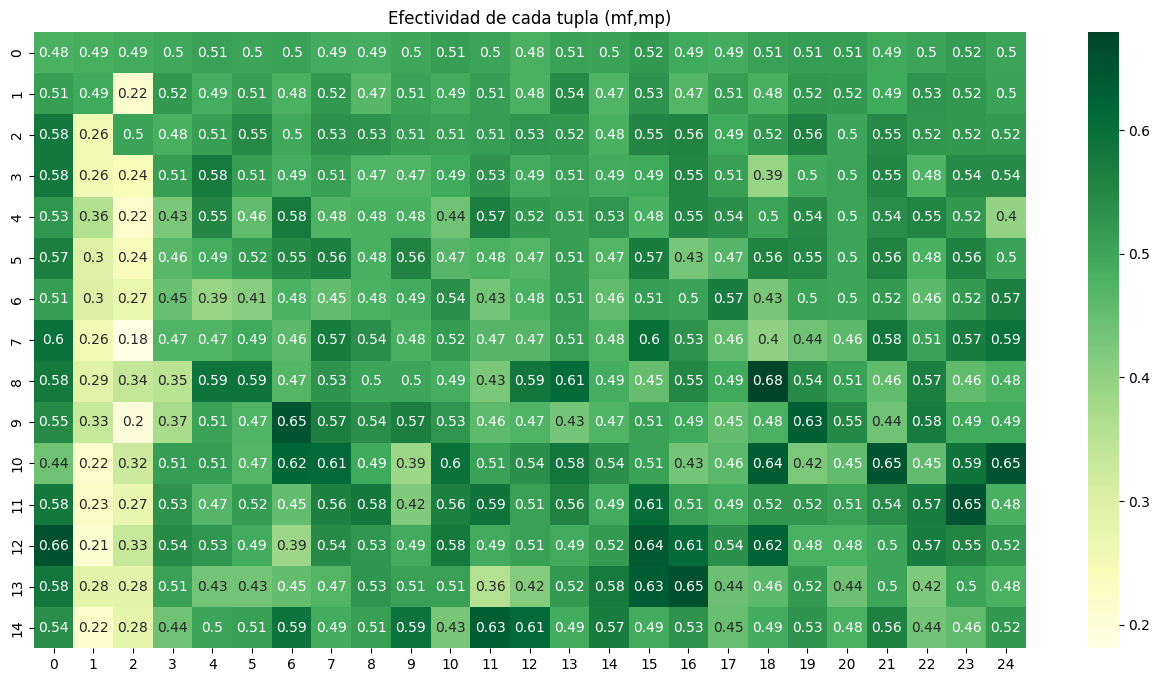

In [24]:
HotSpots(15,25, info_tech)

In [62]:
f = open('energy_sector.csv', 'r')
reader = csv.reader(f)
tickers = [i.split(',')[0] for i in f.readlines()]
df = yf.download(tickers, start = "2018-01-01", end="2021-01-01")['Adj Close']
dft = df.T
energy_sector = dft.values
x, y = energy_sector.shape
for i in range(x):
    for j in range(y):
        if np.isnan(energy_sector[i,j]) == True:
            print(f'Nan en {(i,j)}')

[*********************100%***********************]  23 of 23 completed


C:\Users\Pedro\AppData\Local\Temp\ipykernel_128\3108260181.py:4: RuntimeWarning: invalid value encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))
C:\Users\Pedro\AppData\Local\Temp\ipykernel_128\3108260181.py:4: RuntimeWarning: overflow encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))


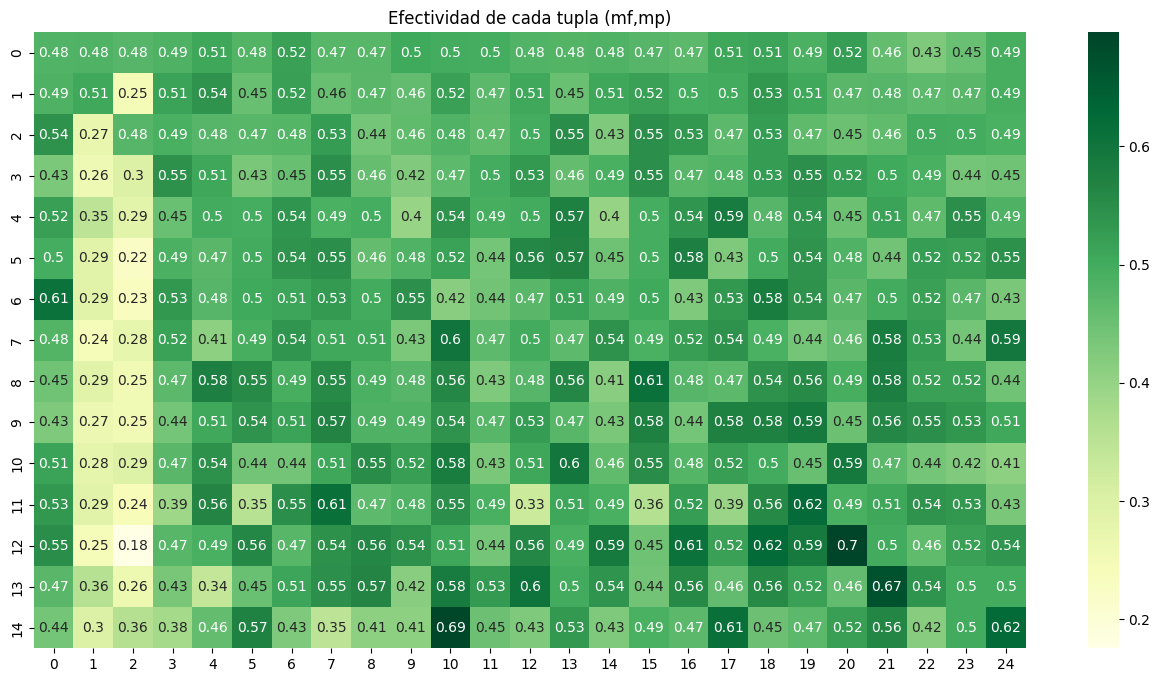

In [28]:
HotSpots(15,25, energy_sector)

In [63]:
f = open('consumer_staples.csv', 'r')
reader = csv.reader(f)
tickers = [i.split(',')[0] for i in f.readlines()]
df = yf.download(tickers, start = "2018-01-01", end="2021-01-01")['Adj Close']
dft = df.T
consumer_staples = dft.values
x, y = consumer_staples.shape
for i in range(x):
    for j in range(y):
        if np.isnan(consumer_staples[i,j]) == True:
            print(f'Nan en {(i,j)}')

[*********************100%***********************]  32 of 32 completed


C:\Users\Pedro\AppData\Local\Temp\ipykernel_128\184215239.py:4: RuntimeWarning: invalid value encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))
C:\Users\Pedro\AppData\Local\Temp\ipykernel_128\184215239.py:4: RuntimeWarning: overflow encountered in power
  return np.real(np.dot(np.dot(np.dot(Phi, np.power(np.diag(mu), t/dt)), np.linalg.pinv(Phi)), A[:,0]))


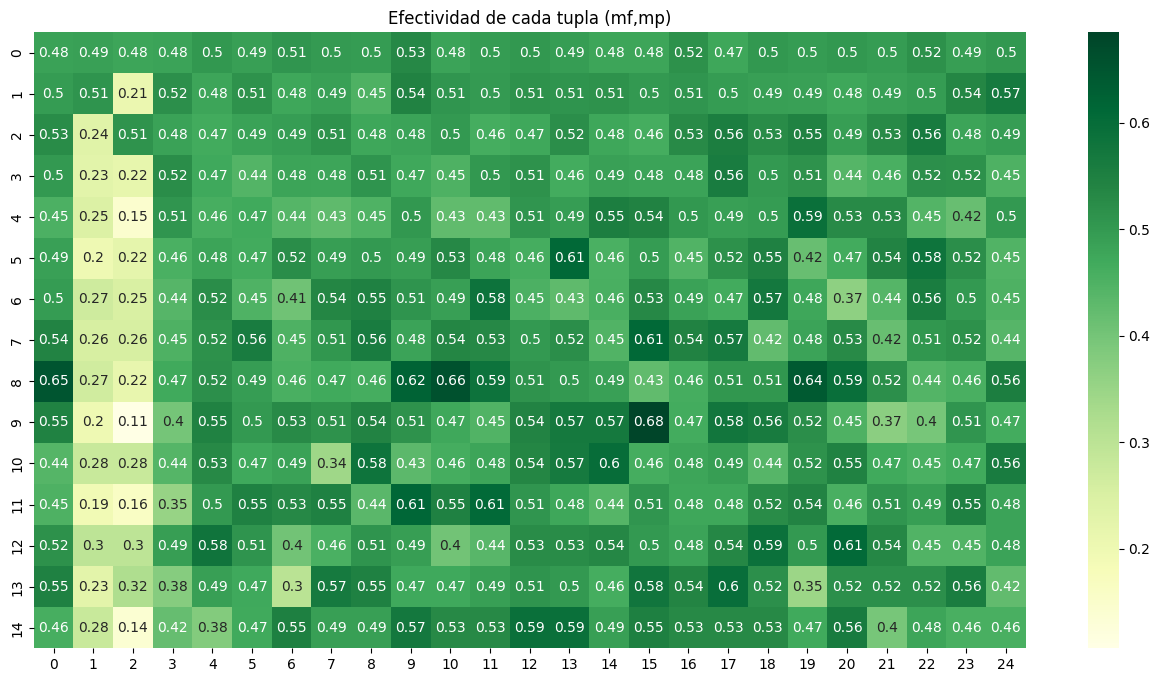

In [35]:
HotSpots(15,25, consumer_staples)

In [135]:
consumidor0 = resultado(7,10, consumerdiscr)   
sector_financiero = resultado(18,13,financial_sector)
salud = resultado(18,13,health_care)
tech = resultado(16,13,info_tech)
consumidor1 = resultado(11,9,consumer_staples)
energia = resultado(7,7,energy_sector)

In [104]:
#En este codigo se obtiene la data del S&P

start_date = datetime.strptime('2018-01-01', '%Y-%m-%d')
end_date =  datetime.strptime('2021-01-01', '%Y-%m-%d')

spy = yf.download('SPY',start_date,end_date)['Adj Close']
spy = spy / spy[0]

spy_np = spy.to_numpy()


[*********************100%***********************]  1 of 1 completed


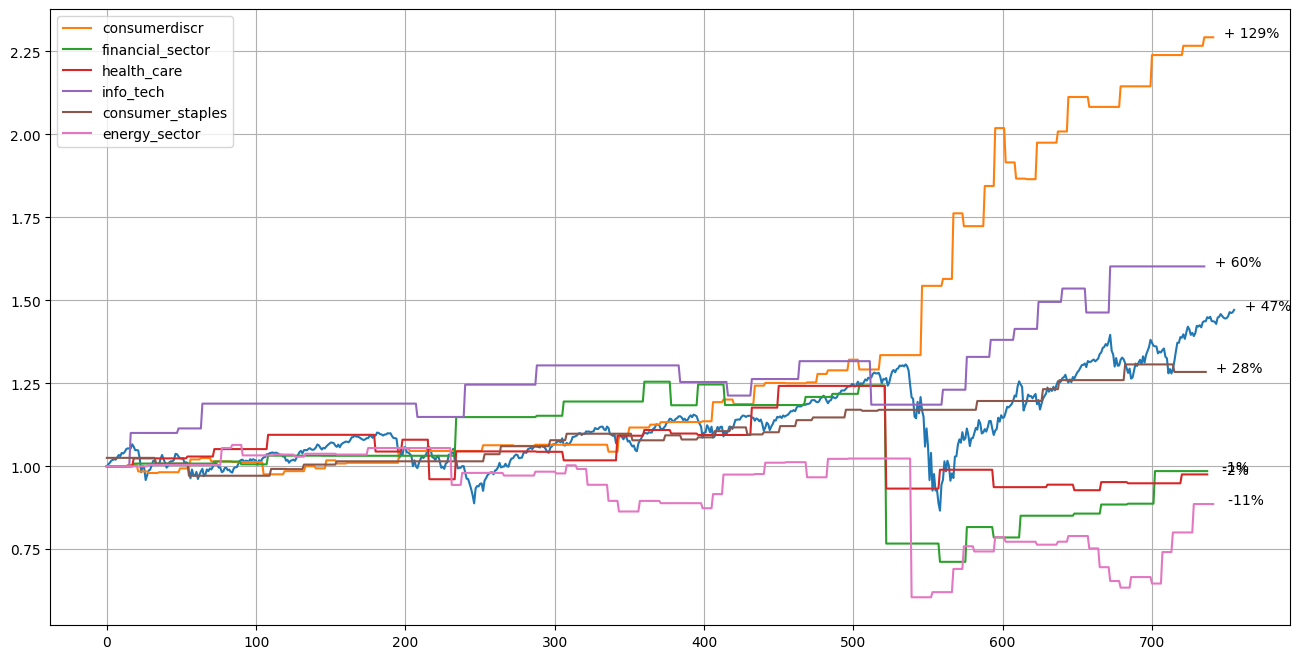

In [136]:
#Se potlean todos los rendimientos juntos

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(spy_np)
ax.plot(consumidor0, label='consumerdiscr')
ax.plot(sector_financiero, label='financial_sector')
ax.plot(salud, label='health_care')
ax.plot(tech, label='info_tech')
ax.plot(consumidor1, label='consumer_staples')
ax.plot(energia, label='energy_sector')
Indices = [spy, consumidor0, sector_financiero, salud, tech, consumidor1, energia]

for i in Indices:
    v = i[-1] - 1
    if np.sign(v) < 0:
        s = f'   {v:.0%}'
    else:
        s = f'  + {v:.0%}'
    ax.annotate(s, xy=(len(i), i[-1]), xytext=(0,0), textcoords='offset points', fontsize=10)
ax.legend()
ax.grid()
plt.show()